In [2]:
import nltk
import re
import string
from nltk.corpus import gutenberg, stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from bs4 import BeautifulSoup

In [3]:
def get_text_from_gutenberg(book_ids):
    try:
        nltk.data.find('corpora/gutenberg')
    except LookupError:
        nltk.download('gutenberg')

    text = ""
    for book_id in book_ids:
        try:
            raw_text = gutenberg.raw(book_id)
            print(f"Downloaded '{book_id}' with '{len(raw_text)}' characters.")
            text += raw_text
        except ValueError:
            print(f"Book ID '{book_id}' not found in the Gutenberg corpus.")
    return text

In [4]:
book_ids = ['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt']
text = get_text_from_gutenberg(book_ids) 
print(text)

Downloaded 'austen-emma.txt' with '887071' characters.
Downloaded 'austen-persuasion.txt' with '466292' characters.
Downloaded 'austen-sense.txt' with '673022' characters.
[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.  Her mother
had died too long ago for her to have more than an indistinct
remembrance of her caresses; and her place had been supplied
by an excellent woman as governess, who had fallen little short
of a mother in affection.

Sixteen years had Miss Taylor been in Mr. Woodhouse's family,
less as a governess than a friend, very fond of both daughters

In [21]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')  # Required for nltk.word_tokenize

def clean_text(text):
    # text = text.lower()  # Lowercase
    text = re.sub(r'^[^\n]*[A-Za-z]+\sby\s[A-Za-z]+\s[A-Za-z]+\s\d{4}.*\n', '', text)  # Remove title lines
    text = re.sub(r'\b(volume|chapter)\b.*\n', '', text)  # Remove volume/chapter headers
    text = re.sub(r'(\bTHE\sEND\b.*\n)', '', text)  # Remove "THE END" section
    # text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation / special characters
    text = re.sub(r'\n+', '\n', text)  # Remove extra newlines
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace

    # words = nltk.word_tokenize(text)  # Tokenize
    # stop_words = set(stopwords.words('english'))
    # words = [word for word in words if word not in stop_words]  # Now remove stopwords
    
    return cleaned_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tanyasharan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tanyasharan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
# Generate the cleaned_text using the clean_text function
cleaned_text = clean_text(text)

# Print the first 20 characters of the cleaned text
print(cleaned_text[:200])

emma woodhouse handsome clever rich comfortable home happy disposition seemed unite best blessings existence lived nearly twentyone years world little distress vex youngest two daughters affectionate 


In [23]:
! pip install spacy
! python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.5 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import spacy
from collections import Counter

# Load the spaCy English model (you should have installed it already)
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2_000_000 

def generate_list_spacy(text, num_words=100):
    doc = nlp(text)

    # Extract lemmatized content words (nouns, verbs, adjectives, adverbs)
    content_words = [
        token.lemma_ for token in doc
        if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']
        and not token.is_stop # Removes stopwords 
        and token.is_alpha # Removes punctuation without regex
    ]

    # Get the most common ones
    word_freq = Counter(content_words)
    most_common = word_freq.most_common(num_words)
    
    # Return only the words, not their frequencies
    L = [word for word, freq in most_common]
    
    return L

In [25]:
L = generate_list_spacy(cleaned_text)
print(f"Length of list L: {len(L)}")
print(L)

Length of list L: 100
['say', 'think', 'know', 'come', 'thing', 'good', 'time', 'little', 'great', 'elinor', 'see', 'look', 'feel', 'soon', 'man', 'go', 'long', 'hear', 'friend', 'day', 'wish', 'miss', 'sister', 'speak', 'find', 'give', 'tell', 'young', 'sure', 'dear', 'leave', 'well', 'hope', 'believe', 'talk', 'want', 'mother', 'lady', 'way', 'moment', 'mean', 'take', 'happy', 'woman', 'harriet', 'place', 'feeling', 'emma', 'love', 'mind', 'walk', 'return', 'room', 'manner', 'captain', 'letter', 'word', 'home', 'begin', 'suppose', 'year', 'bring', 'poor', 'reply', 'family', 'far', 'present', 'visit', 'morning', 'hour', 'pleasure', 'heart', 'away', 'pass', 'body', 'child', 'cry', 'subject', 'sit', 'spirit', 'father', 'eye', 'thought', 'certainly', 'understand', 'party', 'appear', 'marry', 'evening', 'turn', 'answer', 'house', 'doubt', 'world', 'ask', 'idea', 'colonel', 'life', 'opinion', 'live']


In [ ]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import nltk

# Ensure NLTK sentence & word tokenizer is available
nltk.download('punkt')

def word2vec_similarity_matrix(cleaned_text, L):
    """
    Trains a Word2Vec model on the cleaned text and computes
    a cosine similarity matrix for the given word list L.

    Parameters:
        cleaned_text (str): Preprocessed text.
        L (list): List of target words to compare.

    Returns:
        similarity_matrix (np.array): 2D array of cosine similarities.
        word_list (list): Words actually found in the model (order matches matrix).
    """
    # Sentence and word tokenization
    sentences = nltk.sent_tokenize(cleaned_text)
    tokenized_sentences = [nltk.word_tokenize(sentence.lower()) for sentence in sentences]

    # Train Word2Vec model
    model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=7, min_count=1, workers=4)

    # Build word vector dictionary (only keep words found in the model)
    word_vectors = {word: model.wv[word] for word in L if word in model.wv}
    word_list = list(word_vectors.keys())  # Preserve order for matrix labeling

    # Initialize similarity matrix
    similarity_matrix = np.zeros((len(word_list), len(word_list)))

    # Fill the similarity matrix with cosine similarities
    for i in range(len(word_list)):
        for j in range(i + 1, len(word_list)):
            vec1 = word_vectors[word_list[i]]
            vec2 = word_vectors[word_list[j]]

            similarity = cosine_similarity([vec1], [vec2])[0][0]

            # Symmetric matrix
            similarity_matrix[i][j] = similarity
            similarity_matrix[j][i] = similarity

    return similarity_matrix, word_list

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tanyasharan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
similarity_matrix, word_list = word2vec_similarity_matrix(cleaned_text, L)

# Optional: convert to distance matrix for clustering
distance_matrix = 1 - similarity_matrix

# Preview
print(f"Similarity matrix shape: {similarity_matrix.shape}")
print("Words in matrix:", word_list[:10])  # First 10 words

Similarity matrix shape: (100, 100)
Words in matrix: ['say', 'think', 'know', 'come', 'thing', 'good', 'time', 'little', 'great', 'elinor']


In [28]:
distance_matrix = 1 - similarity_matrix
print(distance_matrix)

[[1.         0.30161226 0.40906733 ... 0.51441917 0.64160702 0.91945065]
 [0.30161226 1.         0.31693453 ... 0.35887396 0.6143865  0.90825564]
 [0.40906733 0.31693453 1.         ... 0.49462754 0.68702731 0.9594078 ]
 ...
 [0.51441917 0.35887396 0.49462754 ... 1.         0.77362347 0.97875568]
 [0.64160702 0.6143865  0.68702731 ... 0.77362347 1.         0.89191975]
 [0.91945065 0.90825564 0.9594078  ... 0.97875568 0.89191975 1.        ]]


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

def plot_dendrogram(distance_matrix, labels):
    # Perform hierarchical clustering 
    linkage_matrix = linkage(distance_matrix, method='ward')

    # Plot dendrogram
    plt.figure(figsize=(20, 8))
    dendrogram(linkage_matrix, labels=labels, leaf_rotation=90)
    plt.title("Word Clustering Dendrogram (Word2Vec-based Distances)")
    plt.xlabel("Words")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

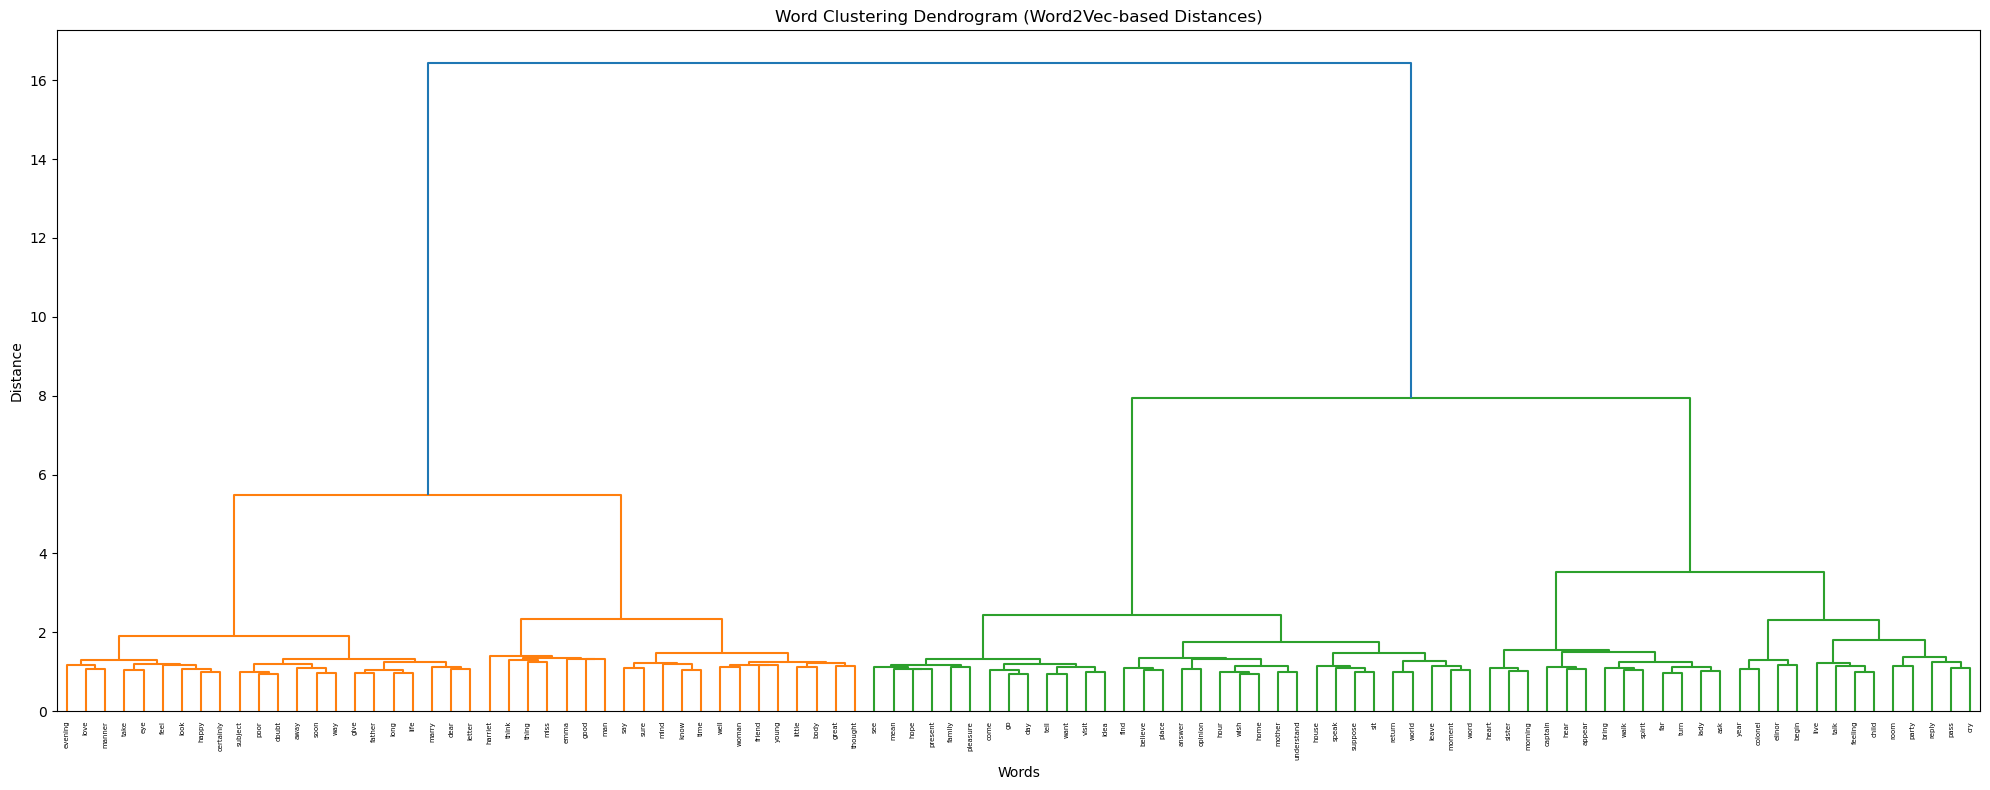

In [30]:
plot_dendrogram(1 - similarity_matrix, word_list)

In [58]:
! pip install networkx

In [59]:
import networkx as nx

def build_word_graph(distance_matrix, labels):
    
    G = nx.Graph()
    
    # Add nodes
    for label in labels:
        G.add_node(label)
    
    # Add weighted edges
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            word1 = labels[i]
            word2 = labels[j]
            weight = distance_matrix[i][j]
            G.add_edge(word1, word2, weight=weight)
    
    return G

def shortest_path_distance(G, word1, word2):

    try:
        path = nx.dijkstra_path(G, word1, word2, weight='weight')
        distance = nx.dijkstra_path_length(G, word1, word2, weight='weight')
        return path, distance
    except nx.NetworkXNoPath:
        return None, float('inf')


In [ ]:
# Compute shortest path distance matrix for all word pairs using Dijkstra
def compute_shortest_path_matrix(G, labels):
   
    n = len(labels)
    shortest_path_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            word1, word2 = labels[i], labels[j]
            try:
                distance = nx.dijkstra_path_length(G, word1, word2, weight='weight')
            except nx.NetworkXNoPath:
                distance = float('inf')
            shortest_path_matrix[i][j] = distance
            shortest_path_matrix[j][i] = distance

    return shortest_path_matrix

In [61]:
# Build graph from Word2Vec distances
G = build_word_graph(1 - similarity_matrix, word_list)

# Create new matrix with shortest path distances
shortest_distance_matrix = compute_shortest_path_matrix(G, word_list)

/var/folders/7b/83mynsks5sq70nnwvggc6nq00000gn/T/ipykernel_45366/4216086682.py:6: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



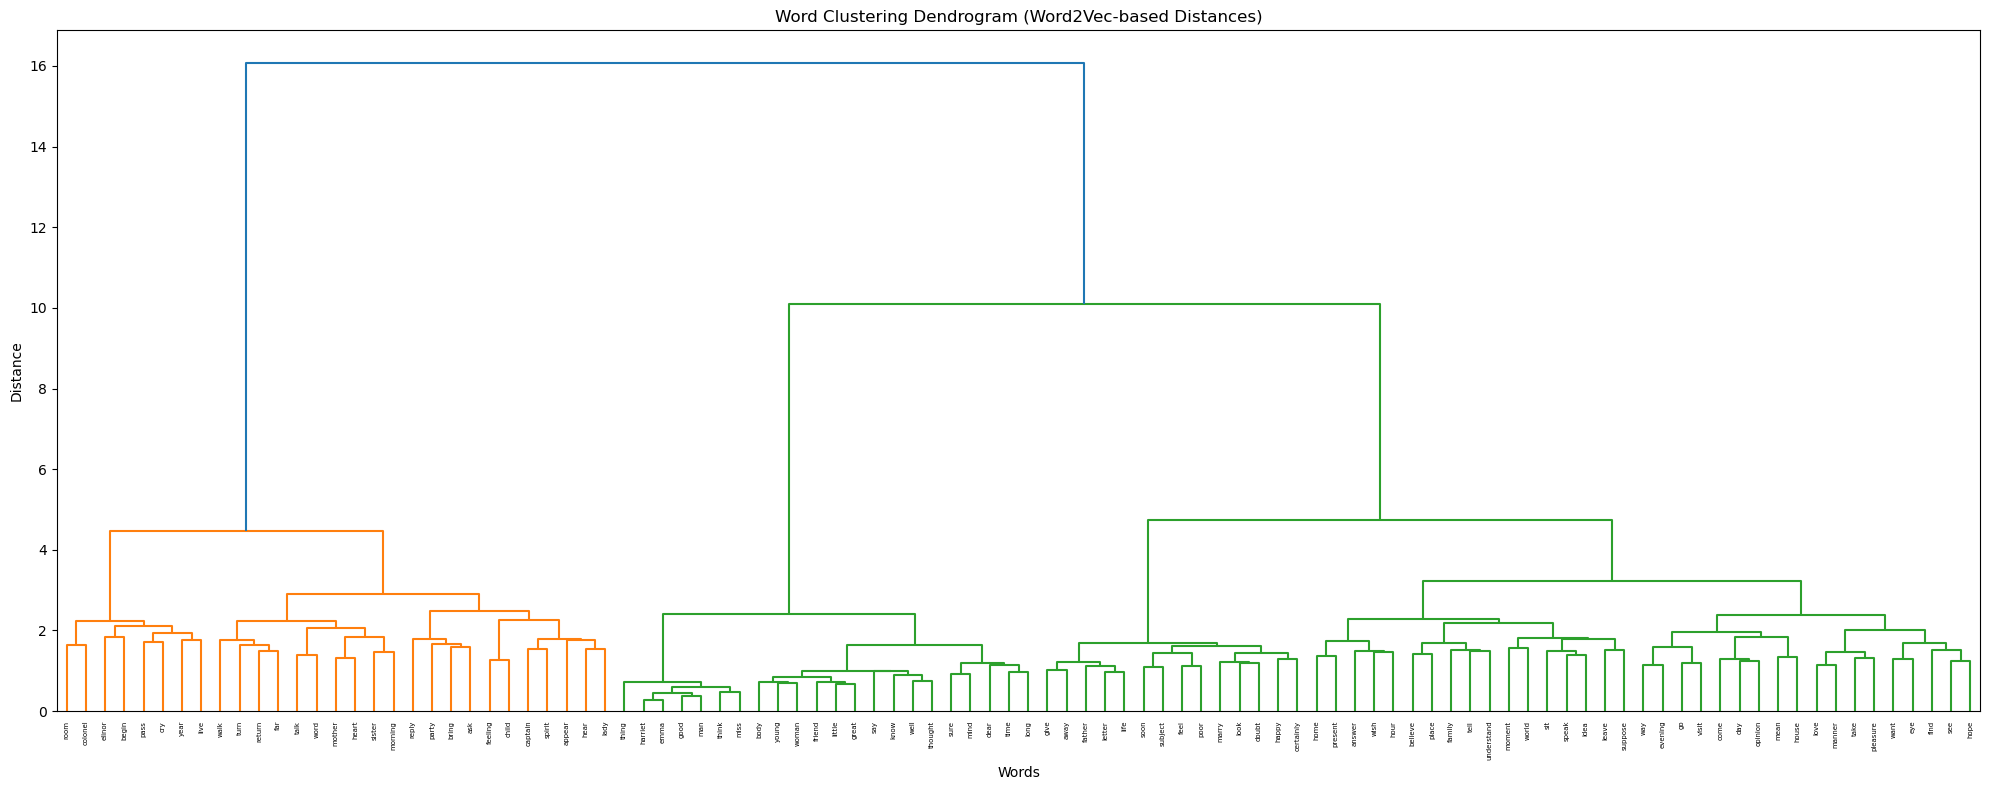

In [62]:
plot_dendrogram(shortest_distance_matrix, word_list)